In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Loading functions
import os
import time
from monai.data import DataLoader, decollate_batch


import torch
import torch.nn.parallel

from src.get_data import CustomDataset
import numpy as np
from scipy import ndimage
from types import SimpleNamespace
import wandb
import logging

#####
import json
import shutil
import tempfile

import matplotlib.pyplot as plt
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
    MapTransform,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data

# from monai.data import decollate_batch
from functools import partial



In [3]:
def fill_holes_3d(mask):
    # Rellenar huecos en la máscara 3D
    filled_mask = ndimage.binary_fill_holes(mask)
    return filled_mask


def expand_mask_3d_td(
    mask, edema, distance_cm_max=0.5, distance_cm_min=0.1, voxel_size=0.1
):
    distance_pixels_max = int(distance_cm_max / voxel_size)
    distance_pixel_min = int(distance_cm_min / voxel_size)

    # Calcular la transformada de distancia
    distance_transform = ndimage.distance_transform_edt(np.logical_not(mask))

    # Crear la nueva máscara alrededor del tumor core
    # expanded_mask_distance = distance_transform >= distance_threshold
    expanded_mask = np.logical_and(
        distance_transform >= distance_pixel_min,
        distance_transform <= distance_pixels_max,
    )

    # Restar la máscara original para obtener solo la región expandida
    exterior_mask = np.logical_and(expanded_mask, np.logical_not(mask))
    # Hacer un AND con el edema para eliminar zonas externas a este
    exterior_mask = np.logical_and(exterior_mask, edema)

    return torch.from_numpy(exterior_mask)


class ConvertToMultiChannel_with_infiltration(MapTransform):
    """
    Convert labels to Nroi + Froi + Edema:
    label 1 is necrosis
    label 2 is edema
    label 3 is activo
    The possible classes are Nroi (ROI cercana), Froi(ROI lejana), Edema
    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []

            # label 1 necro
            necro = d[key] == 1
            # result.append(necro)

            # label 2 is Edema
            edema = d[key] == 2
            # result.append(edema)

            # merge labels 3, 4 and 3 to construct activo
            active = torch.logical_or(d[key] == 3, d[key] == 4)
            # result.append(active)

            # Determinar las ROI cercana y lejana al Tumor Core
            tumor_core_mask = np.logical_or(necro, active)

            # Rellenar los huecos en la máscara
            filled_tumor_core = fill_holes_3d(tumor_core_mask)
            # result.append(torch.from_numpy(filled_tumor_core))

            # Definir el tamaño de voxel en centímetros (ajusta según tus datos)
            voxel_size_cm = 0.1

            # Expandir la máscara de 1 cm alrededor del tumor core (N_ROI)
            N_roi = expand_mask_3d_td(
                filled_tumor_core,
                edema=edema,
                distance_cm_max=0.5,
                distance_cm_min=0.1,
                voxel_size=voxel_size_cm,
            )
            result.append(N_roi)

            F_roi = expand_mask_3d_td(
                filled_tumor_core,
                edema=edema,
                distance_cm_max=10,
                distance_cm_min=1,
                voxel_size=voxel_size_cm,
            )
            result.append(F_roi)
            #result.append(edema)  # comentar para eliminar edema de GT

            d[key] = torch.stack(result, axis=0).float()
        return d


In [4]:
class masked(MapTransform):
     #def __init__(self, keys):
     #     super().__init__(keys)
          
     def __call__(self, data_dict):
          
          B = data_dict["label"]==2
          B=B.unsqueeze(0).expand(11, -1, -1, -1)
          data_dict["image"] = data_dict["image"] * B
          return data_dict
                
    


In [5]:
roi = (128, 128, 64)
t_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        #masked(keys=["image", "label"]),
        ConvertToMultiChannel_with_infiltration(keys="label"),
        transforms.CropForegroundd(
            keys=["image", "label"],
            source_key="image",
            k_divisible=[roi[0], roi[1], roi[2]],
        ),
        transforms.RandSpatialCropd(
            keys=["image", "label"],
            roi_size=[roi[0], roi[1], roi[2]],
            random_size=False,
        ),
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
v_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        #masked(keys=["image", "label"]),
        ConvertToMultiChannel_with_infiltration(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)


c:\Users\Cecilia\AppData\Local\pypoetry\Cache\virtualenvs\unsup-seg-gbm-nLgqUjZ0-py3.11\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [29]:
#dataset_path='./Dataset/Dataset_30_casos/'
dataset_path='./Dataset/Dataset_106_10_casos'

train_set=CustomDataset(dataset_path, section="train",transform=t_transform) # t_transform
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)

im_t=train_set[35]
print(im_t['image'].shape)
print(im_t['label'].shape)


val_set=CustomDataset(dataset_path, section="valid", transform=v_transform) # v_transform
val_loader = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=0)

im_v=val_set[0]
print(im_v['image'].shape)
print(im_v['label'].shape)

Found 106 images and 106 labels.
torch.Size([11, 128, 128, 64])
torch.Size([2, 128, 128, 64])
Found 10 images and 10 labels.
torch.Size([11, 240, 240, 155])
torch.Size([2, 240, 240, 155])


image shape: torch.Size([11, 128, 128, 64])


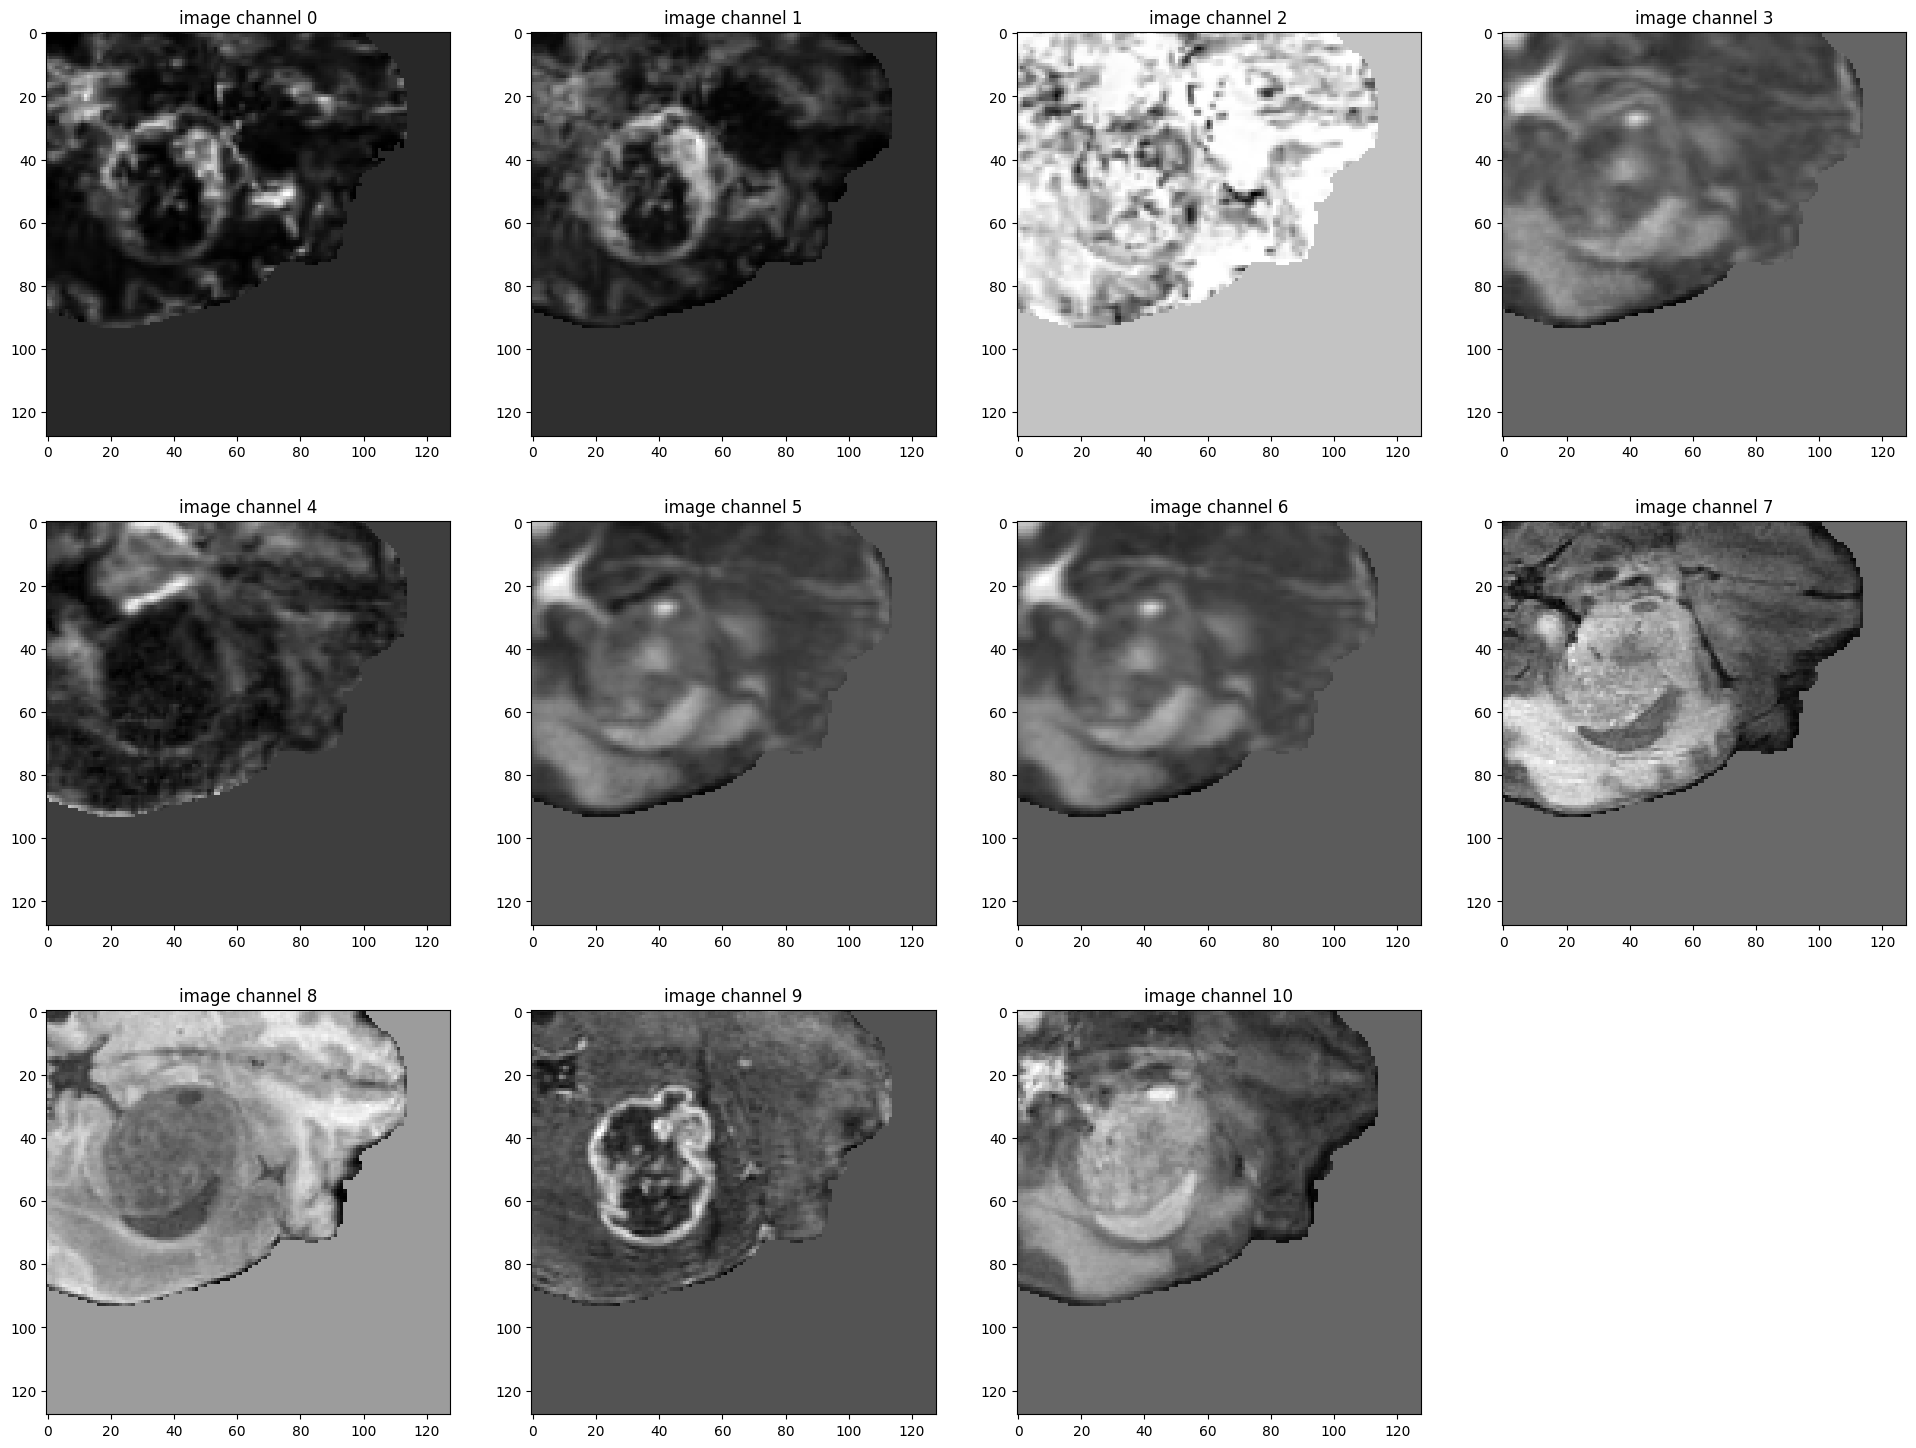

label shape: torch.Size([2, 128, 128, 64])


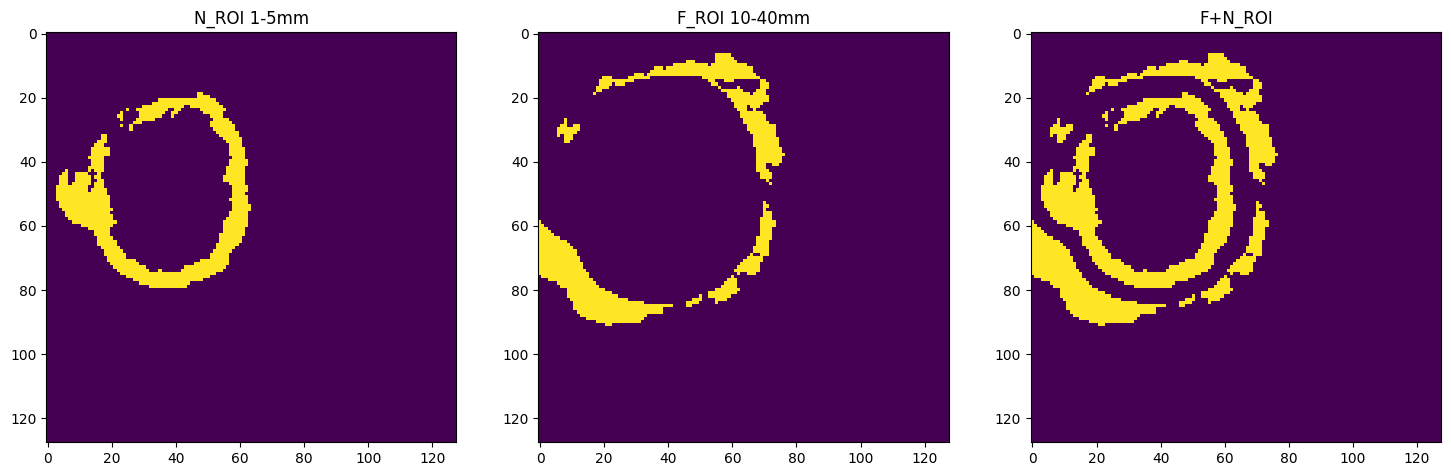

In [32]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
# N_ROI -> hatsa 0.5cm alrededor del TC
# F_ROI -> entre 1 y 4 cm alrededor del TC
val_data_example = train_set[0]
sl=32 #70 32
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 18))
for i in range(11):
    plt.subplot(3, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, sl].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
my_title=['N_ROI 1-5mm', 'F_ROI 10-40mm', 'F+N_ROI']
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"{my_title[i]}")
    if i<2:
        plt.imshow(val_data_example["label"][i, :, :, sl].detach().cpu())
    else:
        im_show=torch.from_numpy(np.logical_or(val_data_example["label"][0, :, :, sl], val_data_example["label"][1, :, :, sl]))
        plt.imshow((im_show).detach().cpu())

plt.show()

## Hacer inferencia con los modelos y visualizar

In [6]:
######################
# Crear el modelo
######################

### Hyperparameter
roi = (128, 128, 64)  # (128, 128, 128)

# Create Swin transformer
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=11,
    out_channels=2,  # mdificar con edema
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

In [7]:
#############################
### Trar modelo desde WandB
#############################

# mlops-team89/Swin_UPENN/93rp3g83_best_model:v0  -> cerebro_nroi+froi
# mlops-team89/Swin_UPENN/sq1r37ci_best_model:v0  -> cerebro_nroi+froi+edema

run = wandb.init()
artifact = run.use_artifact('mlops-team89/Swin_UPENN_106cases/8fhm3ha5_best_model:v0', type='model')
artifact_dir = artifact.download()
print(artifact_dir)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: muletdelosreyes89 (mlops-team89). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact 8fhm3ha5_best_model:v0, 244.53MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:1:4.6


.\artifacts\8fhm3ha5_best_model-v0


In [8]:
#model.load_state_dict(torch.load(os.path.join(artifact_dir, "model.pt"), map_location=torch.device('cpu')))

model_path = os.path.join(artifact_dir, "model.pt")
#model_path = os.path.join('./trained_models', "model.pt")

# Load the model on CPU
loaded_model = torch.load(model_path, map_location=torch.device('cpu'))["state_dict"]

# Load the state dictionary into the model
model.load_state_dict(loaded_model)

# Move the model to the desired device (e.g., GPU) if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()


SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(11, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_featur

In [9]:
dataset_path='./Dataset/Dataset_106_10_casos'
train_set=CustomDataset(dataset_path, section="test", transform=v_transform) # v_transform
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)

Found 4 images and 4 labels.


## Funciones para la inferencia

In [10]:
def inference(input, model, VAL_AMP=False):
    # if config_train.use_autocast:
    #    VAL_AMP = True
    # else:
    #    VAL_AMP = False

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(224, 224, 128),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)
    
roi_t= (224, 224, 128)
model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi_t[0], roi_t[1], roi_t[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)            

In [11]:
def imprimir_inferencia(serie, seg_out, seg, slice, recurrence=False):
    slice_num = slice
    if recurrence:
        s=2
        Path=os.path.join("./Dataset",
                          f"Dataset_106_10_casos/recurrence/images_structural/UPENN-GBM-{serie}_21/UPENN-GBM-{serie}_21_T1GD.nii.gz")
    else:
        s=1
        Path=os.path.join("./Dataset",
                          f"Dataset_106_10_casos/test/images/images_structural/UPENN-GBM-{serie}_{s}1/UPENN-GBM-{serie}_{s}1_T1GD.nii.gz")

    img_add = Path
    
    label_add = os.path.join(
            "./Dataset",
            f"Dataset_106_10_casos/test/labels/UPENN-GBM-{serie}_11_segm.nii.gz",
        )
    if not os.path.exists(label_add):
        label_add = os.path.join(
            "./Dataset",
            f"Dataset_106_10_casos/test/labels/UPENN-GBM-{serie}_11_automated_approx_segm.nii.gz",
        )

    img = nib.load(img_add).get_fdata()
    label = nib.load(label_add).get_fdata()

    plt.figure("image", (18, 18))

    plt.subplot(3, 3, 1)
    plt.title("image")
    plt.imshow(img[:, :, slice_num], cmap="gray")

    plt.subplot(3, 3, 2)
    plt.title("label")
    plt.imshow(label[:, :, slice_num])

    plt.subplot(3, 3, 3)
    plt.title("nroi - froi - inter.")
    plt.imshow(seg_out[:, :, slice_num])

    plt.subplot(3, 3, 4)
    plt.title("Map nroi")
    plt.imshow(seg[0][:, :, slice_num])

    plt.subplot(3, 3, 5)
    plt.title("Map froi")
    plt.imshow(seg[1][:, :, slice_num])

    plt.show()

In [ ]:
n = 3
sl = 60
cases =['00036', '00042','00045', '00051' ]
with torch.no_grad():
    for i, batch_data in enumerate(train_loader):
        if i == n:
            image = batch_data["image"].to('cpu')
            logit=model_inferer_test(image) #inference / model_inferer_test
            prob_sig = torch.sigmoid(logit)
            seg = prob_sig[0].detach().cpu().numpy()

            #seg = (seg > 0.5).astype(np.int8)
            #seg_prob_map = seg[0]
            #seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
            #seg_out[seg[1] == 1] = 1
            #seg_out[seg[0] == 1] = 2
            # seg_out[seg[2] == 1] = 4

            seg = prob_sig[0].detach().cpu().numpy()
            seg1 = (seg > 0.9).astype(np.int8)
            seg_out = np.zeros((seg1.shape[1], seg1.shape[2], seg1.shape[3]))
            seg_out[seg1[1] == 1] = 1
            seg_out[seg1[0] == 1] = 3

            # Nueva línea para la intersección utilizando 'and'
            seg_out[(seg1[0] == 1) & (seg1[1] == 1)] = 2

            # Imprimir
            serie= cases[n]
            # Guardar el valor de la variable en un archivo
            np.save(f'trained_models/seg_{serie}.npy', seg)
            np.save(f'trained_models/seg_out_{serie}.npy', seg_out)

            # Imprimir
            imprimir_inferencia(serie, seg_out, seg, 60)
            break
        #i+=1

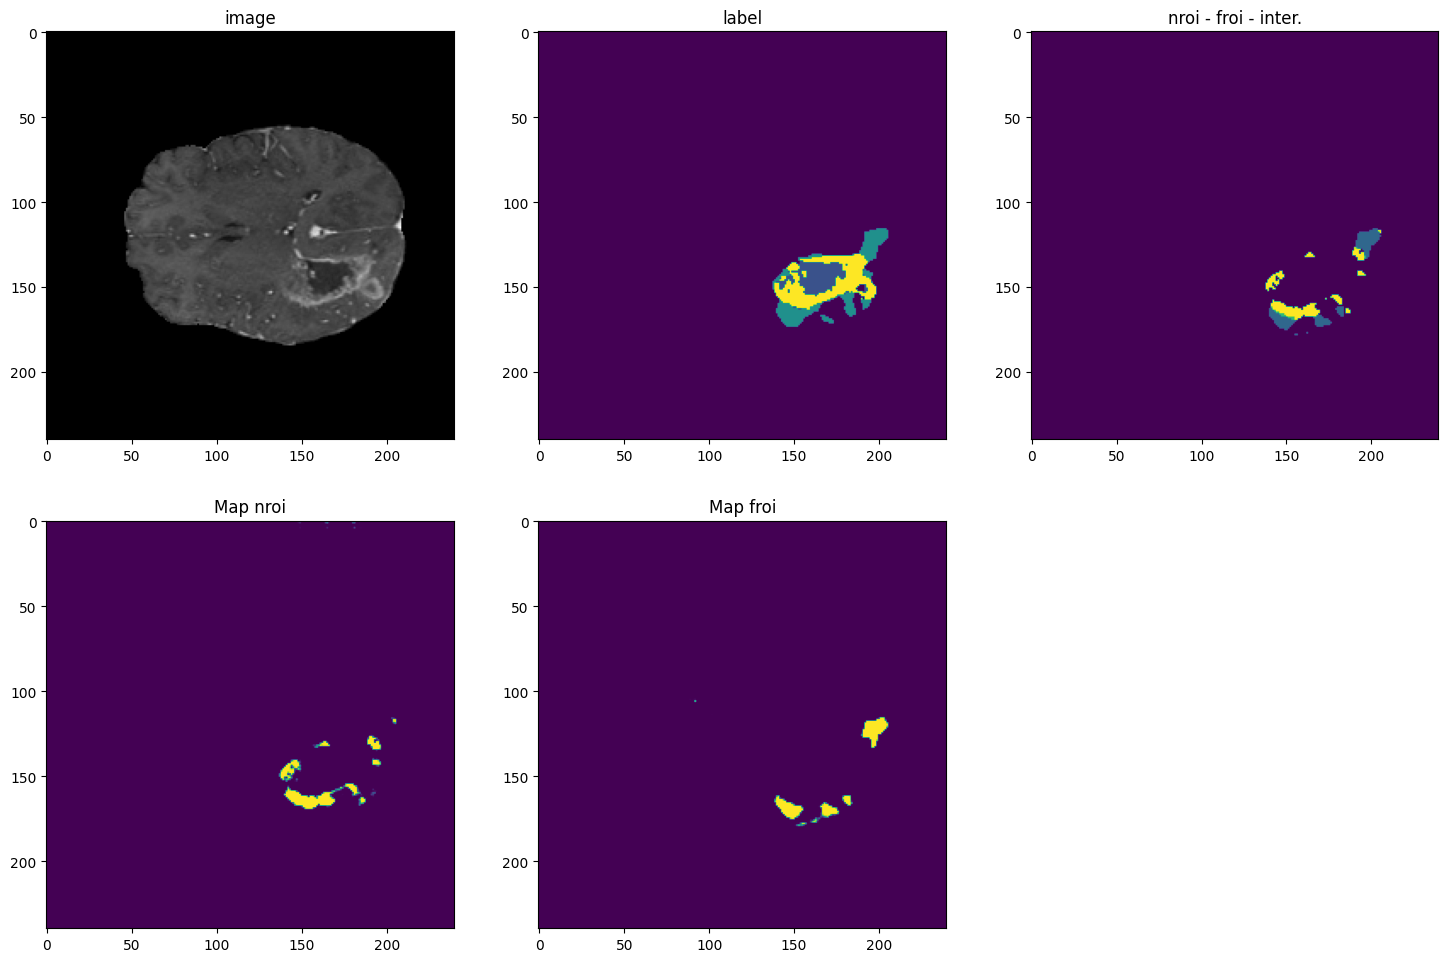

In [51]:
# Imprimir
# cases =['00036', '00042','00045', '00051' ]
n=2
slice = 70
serie=cases[n]
seg_out = np.load(f'trained_models/seg_out_{serie}.npy')
seg = np.load(f'trained_models/seg_{serie}.npy')
imprimir_inferencia(serie, seg_out, seg, slice=slice)

## Visualizar con imagenes de recurrencia

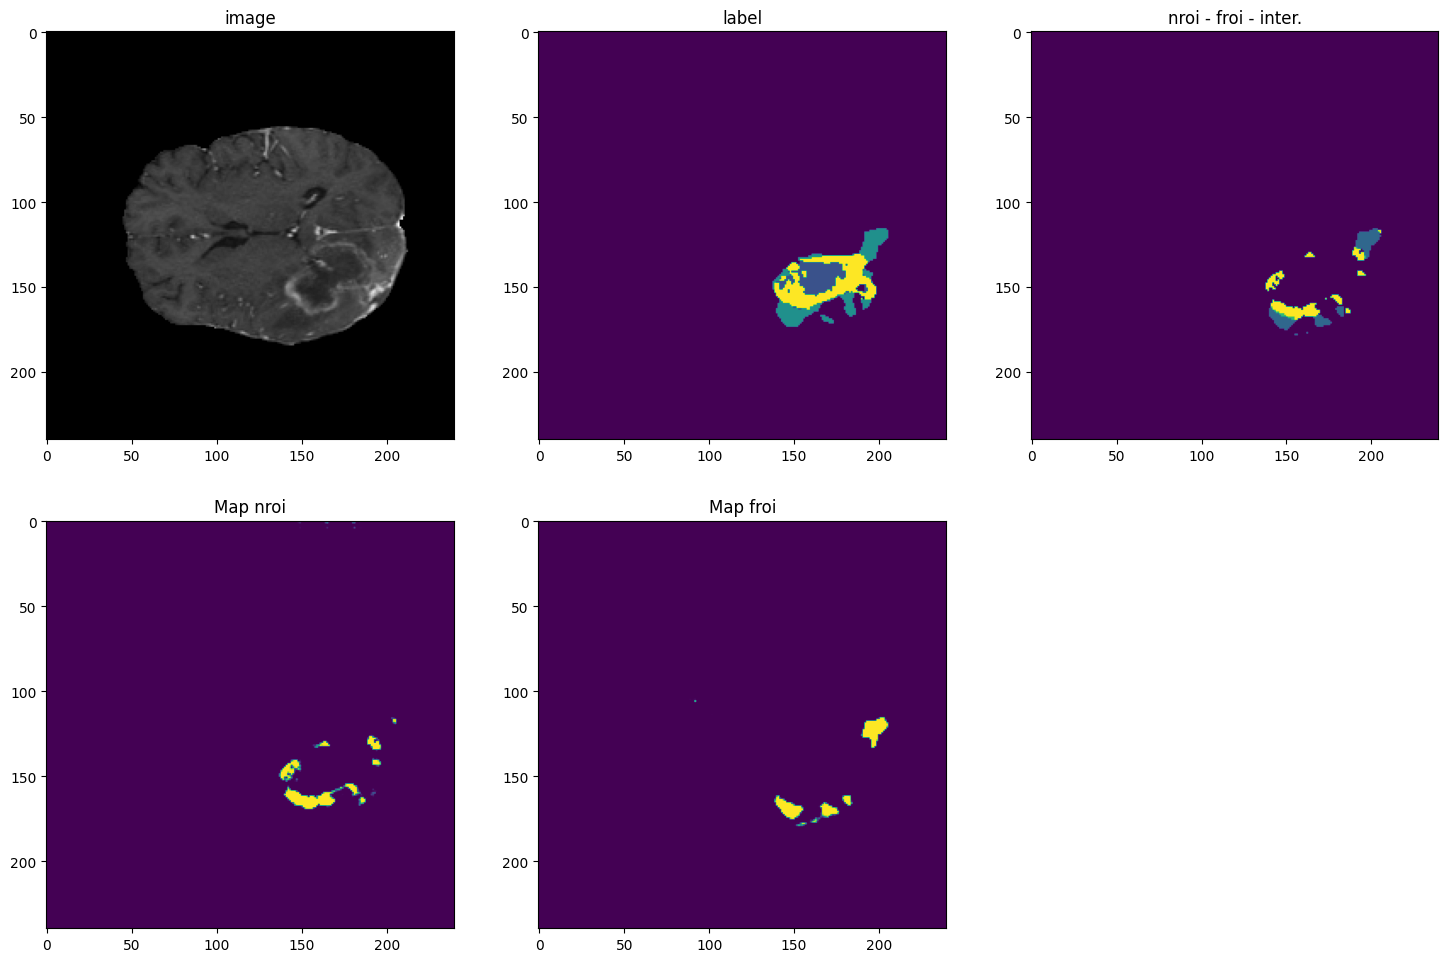

In [49]:
# Imprimir
# cases =['00036', '00042','00045', '00051' ]
serie=cases[n]
slice=70
imprimir_inferencia(serie, seg_out, seg, slice=slice, recurrence=True)